In [1]:
import pandas as pd
import numpy as np

### Import des datasets

In [2]:
title_basics = pd.read_csv("title.basics.tsv.gz", sep = "\t", low_memory=False)
title_basics.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [3]:
title_ratings = pd.read_csv("title.ratings.tsv.gz", sep = "\t")
title_ratings.head()

,tconst,averageRating,numVotes
0,tt0000001,5.7,1829
1,tt0000002,6.0,236
2,tt0000003,6.5,1589
3,tt0000004,6.0,153
4,tt0000005,6.2,2405


In [4]:
title_crew = pd.read_csv("title.crew.tsv.gz", sep = "\t")
title_crew.head()

,tconst,directors,writers
0,tt0000001,nm0005690,\N
1,tt0000002,nm0721526,\N
2,tt0000003,nm0721526,\N
3,tt0000004,nm0721526,\N
4,tt0000005,nm0005690,\N


In [5]:
title_principals = pd.read_csv("title.principals.tsv.gz", sep = "\t")
title_principals.head()

,tconst,ordering,nconst,category,job,characters
0,tt0000001,1,nm1588970,self,\N,"[""Self""]"
1,tt0000001,2,nm0005690,director,\N,\N
2,tt0000001,3,nm0374658,cinematographer,director of photography,\N
3,tt0000002,1,nm0721526,director,\N,\N
4,tt0000002,2,nm1335271,composer,\N,\N


In [6]:
iter_csv = pd.read_csv('title.akas.tsv.gz', sep = "\t", iterator=True, chunksize=1000)
work_akas_FR = pd.concat([chunk[chunk["region"] == "FR"] for chunk in iter_csv])
# Chargement du dataset akas avec selection de la region FR

### Sélection et nettoyage des données sur le datasets title_basics
Après analyse de la base, nous nous sommes rendus compte qu'il fallait convertir certaines données pour les utiliser correctement.
Nous avons aussi fait le choix de réduire pour réduire les temps de calculs. Il a donc fallu choisir des axes de travail pour réduire la base de manière cohérente. Nous avons ici fait le choix de ne travailler que sur les films (et supprimant donc tout ce qui est court métrage, Séries, TvShow...) et de ne pas garder les films pour adultes

In [7]:
# On ne conserve que les films
title_basics = title_basics[title_basics["titleType"] == "movie"]

In [8]:
# On filtre les films IsAdult
title_basics = title_basics[title_basics['isAdult'] == '0']

In [9]:
# on remplace tous les charactères spéciaux par des Nan
title_basics.replace('\\N', np.NAN, inplace = True)

In [10]:
# on remplace les 'inf' par des Nan
title_basics.replace([np.inf, -np.inf], np.nan, inplace=True)

In [11]:
#premier nettoyage des nan
title_basics.dropna(subset=['startYear', 'runtimeMinutes',	'genres'], inplace = True)

In [12]:
#changer types pour les colonnes starYear, runtime
title_basics['startYear'] = title_basics['startYear'].apply(int)
title_basics['runtimeMinutes'] = title_basics['runtimeMinutes'].apply(int)

In [13]:
#analyse de la colonne runtimeMinutes
title_basics['runtimeMinutes'].describe()

count    338136.000000
mean         90.530298
std         135.795773
min           1.000000
25%          75.000000
50%          90.000000
75%         100.000000
max       51420.000000
Name: runtimeMinutes, dtype: float64

<AxesSubplot:>

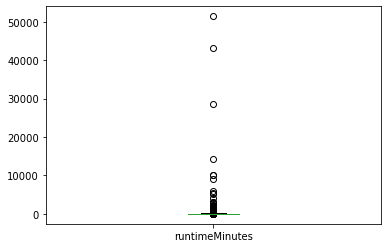

In [14]:
title_basics['runtimeMinutes'].plot.box()

In [15]:
# on ne garde que les fims entre 58 et 270 minutes (outliers)
title_basics = title_basics[(title_basics['runtimeMinutes'] < 270) & (title_basics['runtimeMinutes'] > 58)]

In [16]:
title_basics['startYear'].describe()

count    301708.000000
mean       1994.793850
std          25.638676
min        1896.000000
25%        1979.000000
50%        2006.000000
75%        2015.000000
max        2025.000000
Name: startYear, dtype: float64

<AxesSubplot:>

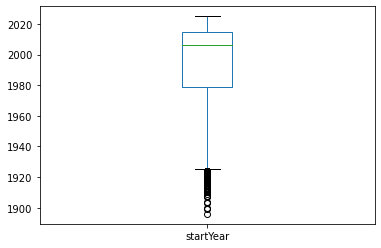

In [17]:
title_basics['startYear'].plot.box()

In [18]:
# On  ne garde que les colonnes qui nous interessent 
title_basics = title_basics[['tconst','primaryTitle', 'originalTitle', 'genres','startYear','runtimeMinutes']]

In [19]:
title_basics.shape

(301708, 6)

### Ajout des ratings et deuxième étape du nettoyage

In [20]:
title_basics_ratings = pd.merge(title_basics, 
                                title_ratings, 
                                how="left", 
                                left_on='tconst',
                                right_on='tconst')
title_basics_ratings.head()

,tconst,primaryTitle,originalTitle,genres,startYear,runtimeMinutes,averageRating,numVotes
0,tt0000591,The Prodigal Son,L'enfant prodigue,Drama,1907,90,5.2,16.0
1,tt0000679,The Fairylogue and Radio-Plays,The Fairylogue and Radio-Plays,"Adventure,Fantasy",1908,120,5.3,65.0
2,tt0001790,"Les Misérables, Part 1: Jean Valjean",Les misérables - Époque 1: Jean Valjean,Drama,1913,60,6.0,44.0
3,tt0002026,Anny - Story of a Prostitute,Anny - en gatepiges roman,"Drama,Romance",1912,68,4.0,13.0
4,tt0002101,Cleopatra,Cleopatra,"Drama,History",1912,100,5.1,521.0


In [21]:
# On supprime les films qui n'ont pas de rating
title_basics_ratings = title_basics_ratings[title_basics_ratings['averageRating'].notna()]

In [22]:
#Ajout d'une colonne 'Score IMDB' et réduction à numVotes>1000
C = title_basics_ratings['averageRating'].mean()
m = 1000
title_basics_ratings = title_basics_ratings[title_basics_ratings['numVotes'] >= m]

def scoreIMDB(x):
    v = x['numVotes']
    R = x['averageRating']
    return (v/(v+m) * R) + (m/(m+v) * C)

title_basics_ratings['scoreIMDB'] = title_basics_ratings.apply(scoreIMDB, axis = 1)

In [23]:
#analyse de la colonne 'scoreIMDB'
title_basics_ratings['scoreIMDB'].describe()

count    35614.000000
mean         6.318805
std          0.890654
min          1.129631
25%          5.808633
50%          6.391583
75%          6.896119
max          9.298717
Name: scoreIMDB, dtype: float64

### Ajout du crew pour obtenir la base finale

In [24]:
base_finale = pd.merge(title_basics_ratings, 
                       title_crew,
                       how="left", 
                       left_on='tconst',
                       right_on='tconst')
base_finale.head()

,tconst,primaryTitle,originalTitle,genres,startYear,runtimeMinutes,averageRating,numVotes,scoreIMDB,directors,writers
0,tt0002130,Dante's Inferno,L'Inferno,"Adventure,Drama,Fantasy",1911,71,7.0,2693.0,6.761656,"nm0078205,nm0209738,nm0655824",nm0019604
1,tt0003014,Ingeborg Holm,Ingeborg Holm,Drama,1913,96,7.0,1157.0,6.591931,nm0803705,"nm0472236,nm0803705"
2,tt0003037,Fantomas: The Man in Black,Juve contre Fantômas,"Crime,Drama",1913,61,7.0,1505.0,6.648621,nm0275421,"nm0019855,nm0275421,nm0816232"
3,tt0003165,Fantômas: The Dead Man Who Killed,Le mort qui tue,"Crime,Drama,Mystery",1913,90,7.0,1176.0,6.595494,nm0275421,"nm0019855,nm0275421,nm0816232"
4,tt0003419,The Student of Prague,Der Student von Prag,"Drama,Fantasy,Horror",1913,85,6.5,2010.0,6.373686,"nm0753233,nm0917467","nm0263912,nm0210503"


In [25]:
# nettoyage des Nan
base_finale.dropna(subset=['directors','writers'], inplace = True)

### Sélection et ajout des 3 principaux acteurs de chaque film dans la base finale

In [26]:
#Select sur la base Principals des acteurs numérotées 1 à 3 dans la colonne Ordering
title_principals1 = title_principals[(title_principals['ordering'] == 1) | (title_principals['ordering'] == 2) | (title_principals['ordering'] == 3)]

In [27]:
#pivot pour obtenir le nm des acteurs de chaque films en colonnes
acteurs_3 = title_principals1.pivot( index= 'tconst', columns = 'ordering', values = 'nconst')

In [28]:
#Ajout des 3 colonnes acteurs à la base finale
base_finale = pd.merge(base_finale, 
                       acteurs_3, 
                       how="left", 
                       left_on='tconst',
                       right_on='tconst')
base_finale.head()

,tconst,primaryTitle,originalTitle,genres,startYear,runtimeMinutes,averageRating,numVotes,scoreIMDB,directors,writers,1,2,3
0,tt0002130,Dante's Inferno,L'Inferno,"Adventure,Drama,Fantasy",1911,71,7.0,2693.0,6.761656,"nm0078205,nm0209738,nm0655824",nm0019604,nm0660139,nm0685283,nm0209738
1,tt0003014,Ingeborg Holm,Ingeborg Holm,Drama,1913,96,7.0,1157.0,6.591931,nm0803705,"nm0472236,nm0803705",nm0096737,nm0511806,nm0511903
2,tt0003037,Fantomas: The Man in Black,Juve contre Fantômas,"Crime,Drama",1913,61,7.0,1505.0,6.648621,nm0275421,"nm0019855,nm0275421,nm0816232",nm0622772,nm0107631,nm0577476
3,tt0003165,Fantômas: The Dead Man Who Killed,Le mort qui tue,"Crime,Drama,Mystery",1913,90,7.0,1176.0,6.595494,nm0275421,"nm0019855,nm0275421,nm0816232",nm0622772,nm0107631,nm0577476
4,tt0003419,The Student of Prague,Der Student von Prag,"Drama,Fantasy,Horror",1913,85,6.5,2010.0,6.373686,"nm0753233,nm0917467","nm0263912,nm0210503",nm0917467,nm0074186,nm0758802


In [29]:
# on renomme les colonnes
base_finale.rename(columns={1: "actor1", 2: "actor2", 3: "actor3"}, inplace=True)

In [30]:
# ajout d'une colonne 'actors' sous le même format que les colonnes 'directors' et 'writers'
base_finale['actor2'].fillna('0', inplace = True)
base_finale['actor3'].fillna('0', inplace = True)
base_finale['actors'] = base_finale['actor1']+','+ base_finale['actor2'] +','+ base_finale['actor3']

In [31]:
# on supprime les colones 'actor2' et 'actor3' qui ne nous serviront plus
base_finale.drop(columns=['actor2', 'actor3'], inplace = True)

### Genres : split + get dummies pour pouvoir utiliser la colonne genre

In [32]:
# split de la colonne 'genres' (2mn environ)
genres_split = base_finale['genres'].apply(lambda x : pd.Series(str(x).split(',')))

In [33]:
# renommage colonnes
genres_split.rename(columns={0: "genre1", 1: "genre2", 2: "genre3"}, inplace=True)

In [34]:
# get_dummies sur les colonnes 'genre'
genres_dummies = pd.get_dummies(genres_split, prefix=['','',''], prefix_sep=['','',''], columns=['genre1', 'genre2', 'genre3'])

In [35]:
# cumul des colonnes portant le même nom
genres_dummies = genres_dummies.T.groupby([s for s in genres_dummies.T.index.values]).sum().T

In [36]:
genres_dummies.columns

Index(['Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance',
       'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'],
      dtype='object')

In [37]:
# Concatenation des dataframes base_finale, genres_split, genres_dummies
base_finale =  pd.concat([base_finale, genres_split], axis=1)
base_finale =  pd.concat([base_finale, genres_dummies], axis=1)

### Writers : split de la liste dans des colonnes et sélection des 2 premiers des listes

In [42]:
# split de la colonne writers
writers_split = base_finale['writers'].apply(lambda x : pd.Series(str(x).split(',')))

In [43]:
# on ne garde que le premier writer lorsqu'il y en a plusieurs
writers_split = writers_split.iloc[:,:1]

In [45]:
# on renomme la colonne
writers_split.rename(columns={0: "writer1"}, inplace=True)

In [46]:
# Concatenation des dataframes base_finale, genres_split
base_finale =  pd.concat([base_finale, writers_split], axis=1)

### Directors : split et seléction des 2 premiers

In [47]:
# split de la colonne directors
direct_split = base_finale['directors'].apply(lambda x : pd.Series(str(x).split(',')))

In [48]:
# on ne garde que le premier director lorsqu'il y en a plusieurs
direct_split = direct_split.iloc[:,:1]

In [49]:
# on renomme la colonne
direct_split.rename(columns={0: "director1"}, inplace=True)

In [50]:
# Concatenation des dataframes base_finale, genres_split
base_finale =  pd.concat([base_finale, direct_split], axis=1)

### Ajout d'un colonne avec les temps de films normalisés
N'ayant pas de très bons résultat sur le machine learning on a fait le choix de normaliser 'à la main' la colonne runtime afin de réduire les distances et d'avoir moins d'incidence par rapport aux autres variables

In [51]:
def normalisation(value) :
#On avait gardé que les films entre 58 et 270 minutes     
    return (value-58)/(270-58)

base_finale['runtimeMinutes_norm'] = base_finale['runtimeMinutes'].apply(normalisation)

### Ajout des titres de films en français

In [52]:
# Suppression des types alternative, tv, working, video, dvd, festival
work_akas_FR = work_akas_FR.drop(work_akas_FR[work_akas_FR['types'].isin(['alternative', 'tv', 'working', 'video', 'dvd', 'festival'])].index)

In [53]:
# Tri par code IMDb et types (devrait placer le type imdbDisplay en dernier pour les akas multiples)
work_akas_FR = work_akas_FR.sort_values(by=['titleId', 'types'], ascending=True)

In [54]:
# Suppression des doublons sur le code IMDb (on conserve le dernier qui est imdbDisplay lorsqu'il éxiste)
work_akas_FR = work_akas_FR.drop_duplicates(subset='titleId', keep="last")

In [55]:
# Réduction du dataframe (on ne conserve que la clé et le titre)
work_akas_FR = work_akas_FR[['titleId', 'title']]

In [56]:
# Merge de base_movies avec work_akas_FR
base_finale = pd.merge(base_finale, 
                        work_akas_FR, 
                        how="left", 
                        left_on='tconst',
                        right_on='titleId')
base_finale

,tconst,primaryTitle,originalTitle,genres,startYear,runtimeMinutes,averageRating,numVotes,scoreIMDB,directors,...,Sci-Fi,Sport,Thriller,War,Western,writer1,director1,runtimeMinutes_norm,titleId,title
0,tt0002130,Dante's Inferno,L'Inferno,"Adventure,Drama,Fantasy",1911,71,7.0,2693.0,6.761656,"nm0078205,nm0209738,nm0655824",...,0,0,0,0,0,nm0019604,nm0078205,0.061321,tt0002130,L'enfer
1,tt0003014,Ingeborg Holm,Ingeborg Holm,Drama,1913,96,7.0,1157.0,6.591931,nm0803705,...,0,0,0,0,0,nm0472236,nm0803705,0.179245,NaN,NaN
2,tt0003037,Fantomas: The Man in Black,Juve contre Fantômas,"Crime,Drama",1913,61,7.0,1505.0,6.648621,nm0275421,...,0,0,0,0,0,nm0019855,nm0275421,0.014151,tt0003037,Juve contre Fantômas
3,tt0003165,Fantômas: The Dead Man Who Killed,Le mort qui tue,"Crime,Drama,Mystery",1913,90,7.0,1176.0,6.595494,nm0275421,...,0,0,0,0,0,nm0019855,nm0275421,0.150943,tt0003165,Le mort qui tue
4,tt0003419,The Student of Prague,Der Student von Prag,"Drama,Fantasy,Horror",1913,85,6.5,2010.0,6.373686,"nm0753233,nm0917467",...,0,0,0,0,0,nm0263912,nm0753233,0.127358,tt0003419,L'étudiant de Prague
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35609,tt9902160,Herself,Herself,Drama,2020,97,7.0,2798.0,6.768245,nm1630273,...,0,0,0,0,0,nm7434342,nm1630273,0.183962,tt9902160,Herself
35610,tt9904802,Enemy Lines,Enemy Lines,War,2020,92,4.5,1410.0,5.172114,nm0052054,...,0,0,0,1,0,nm0942647,nm0052054,0.160377,NaN,NaN
35611,tt9911196,The Marriage Escape,De beentjes van Sint-Hildegard,"Comedy,Drama",2020,103,7.6,3204.0,7.247906,nm0631590,...,0,0,0,0,0,nm2063122,nm0631590,0.212264,tt9911196,De Beentjes van Sint-Hildegard
35612,tt9916270,Il talento del calabrone,Il talento del calabrone,Thriller,2020,84,5.8,1201.0,5.945295,nm1480867,...,0,0,1,0,0,nm1480867,nm1480867,0.122642,NaN,NaN


In [57]:
# suppression des colonnes inutiles 
base_finale = base_finale.drop(['titleId'], axis = 1)

In [58]:
# renommage de la colonne titelFR
base_finale.rename(columns={'title': 'titleFR'}, inplace=True)

In [59]:
# Comparaisons entre les 3 titres
# Si primaryTitle != originalTitle et originalTitle = titleFR, on considère que c'est un film FR, on initialise un indicateur 'FR'
base_finale['FR'] = (base_finale['originalTitle'] == base_finale['titleFR']) & (base_finale['originalTitle'] != base_finale['primaryTitle']) 

### Réorganisation des colonnes

In [60]:
base_finale.columns


Index(['tconst', 'primaryTitle', 'originalTitle', 'genres', 'startYear',
       'runtimeMinutes', 'averageRating', 'numVotes', 'scoreIMDB', 'directors',
       'writers', 'actor1', 'actors', 'genre1', 'genre2', 'genre3', 'Action',
       'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi',
       'Sport', 'Thriller', 'War', 'Western', 'writer1', 'director1',
       'runtimeMinutes_norm', 'titleFR', 'FR'],
      dtype='object')

In [63]:
base_finale = base_finale[['tconst', 'primaryTitle', 'originalTitle', 'titleFR', 'FR', 'genres',
 'startYear', 'runtimeMinutes','runtimeMinutes_norm', 'averageRating', 'numVotes','scoreIMDB', 
 'directors', 'writers',  'actors',
 'director1','writer1', 'actor1',
 'genre1', 'genre2', 'genre3', 
 'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 
 'Documentary', 'Drama','Family', 'Fantasy', 'Film-Noir', 'History', 'Horror',
 'Music','Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
 'War', 'Western'
]]

In [ ]:
base_finale.to_csv("/base_movies.csv", index = False)